# Music Genre Classification

* see REAMME.md for necessary conda setup and the MAESTRO dataset download

## Split MAESTRO wavs into 3 minute clips and label with genre
The MAESTRO dataset contains wav files of varying lengths (up to ~20 minutes!) of classical recordings. Basic Pitch cannot make midi predictions on audio that surpasses around 9 minutes. We split the MAESTRO recordings into 3 minute chunks of wav audio.

Imports

In [4]:
import pandas as pd
import math
import re
import os
import librosa
import pickle, lzma
from pydub import AudioSegment

ModuleNotFoundError: No module named 'pydub'

Create a list of audio filepaths

In [1]:
classical_data = pd.read_csv('classical_dataset.csv')

wavs = list(classical_data['audio_filename'])
for i in range(0, len(wavs)):
    wavs[i] = "maestro-v3.0.0/" + wavs[i]

print(wavs)
print(len(wavs))

['maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav', 'maestro-v3.0.0/2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav', 'maestro-v3.0.0/2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.wav', 'maestro-v3.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.wav', 'maestro-v3.0.0/2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.wav', 'maestro-v3.0.0/2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.wav', 'maestro-v3.0.0/2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.wav', 'maestro-v3.0.0/2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.wav', 'maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.wav', 'maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.wav', 'maest

Split audio into chunks
* Audio splitting class adapted from https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files

In [ ]:
class SplitWavAudio():
    def __init__(self, folder, filename, path):
        self.folder = folder
        self.filename = filename
        self.filepath = path
        
        self.audio = AudioSegment.from_file(self.filepath, format="wav")

    
    def get_duration(self):
        """Measures duration of a SplitWavAudio audio attribute

        Returns
        -------
        int
           duration of audio in seconds
        """
        return self.audio.duration_seconds
    
    def single_split(self, from_min, to_min, split_filename):
        """Exports a clip of audio from a SplitWavAudio object to a designated file

        Parameters
        ----------
        from_min : int
            time at beginning of audio clip
        to_min : int
            time at end of audio clip
        split_filename : string
            name of audio file to export to
        """
        t1 = from_min * 60 * 1000
        t2 = to_min * 60 * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '\\' + split_filename, format="wav")
        
    def multiple_split(self, min_per_split):
        """Splits a SplitWavAudio object into segments of equal length and exports them to a folder.
        The last segment of audio will be shorter than the desired length because it will stop when the song ends.

        Parameters
        ----------
        min_per_split : int
            length of audio clip in minutes
        """
        total_mins = math.ceil(self.get_duration() / 60)
        for i in range(0, total_mins, min_per_split):
            split_fn = str(i) + '_' + self.filename # Filenames will be the number of the split, then the audio filename. ex: the second 3 minute clip of "audio.wav" is "2_audio.wav"
            self.single_split(i, i+min_per_split, split_fn)
            print(str(split_fn) + ' Done')
            if i == total_mins - min_per_split:
                print('All split successfully')

new_folder = "maestro_clips"
counter = 0
for fp in wavs:
    print ("current file: ", counter, "/", len(wavs))
    counter += 1
    new_name = fp
    new_name = re.sub("maestro-v3.0.0/[0-9]+/", "", new_name) # resultant directory won't have the year folders present in maestro
    split_wav = SplitWavAudio(new_folder, new_name, fp)
    split_wav.multiple_split(min_per_split=3)

List wav filenames without year folders and generate list of genre labels

In [2]:
classical_data = pd.read_csv('classical_dataset.csv')

wavs = list(classical_data['audio_filename'])
genres = list(classical_data['Genre'])
for i in range(0, len(wavs)):
    wavs[i] = re.sub("[0-9]+/", "", wavs[i]) # Remove the year folders because the clips created above are all in one folder

genre_list = [] # List of classifications (strings)
for i in genres:
    if not i in genre_list:
        genre_list.append(i)

genre_ints = [] # Classifications (as ints) of each maestro file
for i in range(len(genres)):
    j = 0
    while (not(genres[i] == genre_list[j])):
        j += 1
    genre_ints.append(j)

print(wavs)
print(genre_ints)

['MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav', 'MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav', 'MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.wav', 'MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.wav', 'MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.wav', 'MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.wav', 'ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.wav', 'MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09_wav.wav', 'MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_04_Track04_wav.wav', 'ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013_wav--3

Match clips to genre labels

In [3]:
def get_len(wav):
    """Measures the duration of a wav file

    Parameters
    ----------
    wav : string
        audio filepath

    Returns
    -------
    int
        duration of audio file
    """
    length = librosa.get_duration(path=("long_clips/" + wav))
    return length

path = "meastro_clips/"
audio_clips = os.listdir(path) # list of filepaths in the folder of 3 minute clips we just created
clip_genres = [] # list of corresponding genres to each audio file

for clip in audio_clips:
    match_str = re.sub("^[0-9]+_", "", clip) # remove the clip number to match short clips to their corresponding full songs, which have labels
    wav_index = wavs.index(match_str) # index (in wav array) of the full song
    clip_genres.append(genre_ints[wav_index]) # access tje genre of the full song and assign it to the clip

# remove tracks less than 1 minute seconds long
for i in range(len(audio_clips)):
    print(str(i) + "/" + str(len(audio_clips)))
    if (get_len(audio_clips[i]) < 60):
        print("short")
        audio_clips.pop(i)
        clip_genres.pop(i)
    if (i == len(audio_clips) - 1): # len(audio_clips) changes as short tracks are removed. This avoids going out of the bounds of the list
        break

# print(audio_clips[:10])
# print(clip_genres[:10])

# Save list using pickle for easier access later
with lzma.open("audio_clips.xz", "wb") as f:
    pickle.dump(audio_clips, f)
with lzma.open("clip_genres.xz", "wb") as f:
    pickle.dump(clip_genres, f)

0/48460
1/48460
2/48460
3/48460
4/48460
5/48460
6/48460
7/48460
8/48460
9/48460
10/48460
11/48460
12/48460
13/48460
14/48460
15/48460
16/48460
17/48460
18/48460
19/48460
20/48460
21/48460
22/48460
23/48460
24/48460
25/48460
26/48460
27/48460
28/48460
29/48460
30/48460
31/48460
32/48460
33/48460
34/48460
35/48460
36/48460
37/48460
38/48460
39/48460
40/48460
41/48460
42/48460
43/48460
44/48460
45/48460
46/48460
47/48460
48/48460
49/48460
50/48460
51/48460
52/48460
53/48460
54/48460
55/48460
56/48460
57/48460
58/48460
59/48460
60/48460
61/48460
62/48460
63/48460
64/48460
65/48460
66/48460
67/48460
68/48460
69/48460
70/48460
71/48460
72/48460
73/48460
74/48460
75/48460
76/48460
77/48460
78/48460
79/48460
80/48460
81/48460
82/48460
83/48460
84/48460
85/48460
86/48460
87/48460
88/48460
89/48460
90/48460
91/48460
92/48460
93/48460
94/48460
95/48460
96/48460
97/48460
98/48460
99/48460
100/48460
101/48460
102/48460
103/48460
104/48460
105/48460
106/48460
107/48460
108/48460
109/48460
110/48460


KeyboardInterrupt: 

## Extract audio features

Extract openSMILE features

Imports

In [ ]:
import opensmile
import numpy as np
import pandas as pd
import pickle, lzma

In [2]:
def get_smile_feats(audio):
    """Create a feature matrix of openSMILE features from the emobase set (988 total features) for all of the audio clips

    Parameters
    ----------
    audio : list
        filepaths to audio clips

    Returns
    -------
    np.array
        array of features for each audio clip. 988 columns for each of 988 features. len(audio) rows (one row for every audio clip).
    """
    # create smile object for feature extraction
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.emobase,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    all_smiles = [] # list of smile features for each clip
    iters = 0
    for file in audio:
        iters += 1
        print(str(iters) + "/" + str(len(audio)))
        
        # get smile features
        smile_feats = smile.process_file('wav_clips/' + file)
        # convert from df to list
        smile_feats = smile_feats.values.tolist()
        # convert from 2d list to 1d list
        smile_feats = sum(smile_feats, [])
        all_smiles.append(smile_feats)

    feature_array = np.asarray(all_smiles)
    
    return feature_array

if (not(audio_clips in locals())): # load from pickle file if needed
    with lzma.open("audio_clips.xz", "rb") as f:
        audio_clips = pickle.load(f)

smile_features = get_smile_feats(audio_clips)

with lzma.open("smile_features.xz", "wb") as f:
    pickle.dump(smile_features, f)


1/48035
2/48035
3/48035
4/48035
5/48035
6/48035
7/48035
8/48035
9/48035
10/48035
11/48035
12/48035
13/48035
14/48035
15/48035
16/48035
17/48035
18/48035
19/48035
20/48035
21/48035
22/48035
23/48035
24/48035
25/48035
26/48035
27/48035
28/48035
29/48035
30/48035
31/48035
32/48035
33/48035
34/48035
35/48035
36/48035
37/48035
38/48035
39/48035
40/48035
41/48035
42/48035
43/48035
44/48035
45/48035
46/48035
47/48035
48/48035
49/48035
50/48035
51/48035
52/48035
53/48035
54/48035
55/48035
56/48035
57/48035
58/48035
59/48035
60/48035
61/48035
62/48035
63/48035
64/48035
65/48035
66/48035
67/48035
68/48035
69/48035
70/48035
71/48035
72/48035
73/48035
74/48035
75/48035
76/48035
77/48035
78/48035
79/48035
80/48035
81/48035
82/48035
83/48035
84/48035
85/48035
86/48035
87/48035
88/48035
89/48035
90/48035
91/48035
92/48035
93/48035
94/48035
95/48035
96/48035
97/48035
98/48035
99/48035
100/48035
101/48035
102/48035
103/48035
104/48035
105/48035
106/48035
107/48035
108/48035
109/48035
110/48035
111/4803

load from pickle

In [3]:
with lzma.open('smile_features.xz', 'rb') as f:
    smile_features = pickle.load(f)

print (smile_features.shape)

(48035, 988)


MIDI features
* raw wav audio is converted to pretty_midi objects using basic pitch, then features are extracted from MIDI data

Imports

In [6]:
import pickle
import lzma
import pretty_midi as pm
import pandas as pd
import numpy as np
import tensorflow as tf
from basic_pitch.inference import predict as bp_predict
from basic_pitch import ICASSP_2022_MODEL_PATH
BASIC_PITCH_MODEL = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))
from chord_detection.chord_detection_pyfile import *


In [9]:
def predict(filestr):
    """Makes a Basic Pitch prediction with the global parameters above given an input audio file.

    Parameters
    ----------
    filestr : string
        The path to the input audio file.

    Returns
    -------
    midi_data : pm.PrettyMIDI
        PrettyMIDI object containing predicted MIDI notes.
    """
    # Run prediction
    STD_ONSET = 0.3
    STD_FRAME = 0.2
    STD_MIN_NOTE_LEN = 50
    STD_MIN_FREQ = None
    STD_MAX_FREQ = 3000
    
    model_output, midi_data, note_events = bp_predict(
        filestr,
        BASIC_PITCH_MODEL,
        STD_ONSET,
        STD_FRAME,
        STD_MIN_NOTE_LEN,
        STD_MIN_FREQ,
        STD_MAX_FREQ
    ) # midi_data is the PrettyMIDI object corresponding to the prediction
    return midi_data

def get_matched_midi(audio, genres):
    """Creates pretty-midi objects from input .wav files
    Matches each MIDI object with a composition year based on the years list

    Parameters
    ----------
    audio : list
        list of audio filepaths.
    genres : list
        list of genres for each .wav file

    Returns
    -------
    df : pd.DataFrame
        A DataFrame containing the pretty_midi obj and the corresponding genre
    """
    prettys = [] # list of pretty_midi objects

    iters = 0
    for i in range(len(audio)):
        print(str(iters) + "/" + str(len(audio)))
        iters += 1

        midi_obj = predict("wav_clips/" + audio[i]) # uses basic pitch to convert wav to MIDI
        prettys.append(midi_obj)

    df = pd.DataFrame({'midi_obj': prettys, 'genre': genres})

    return df

if (not(audio_clips in locals())): # load from pickle file if needed
    with lzma.open("audio_clips.xz", "rb") as f:
        audio_clips = pickle.load(f)

if (not(clip_genres in locals())): # load from pickle file if needed
    with lzma.open("clip_genres.xz", "rb") as f:
        audio_clips = pickle.load(f)

matched_midi_df = get_matched_midi(audio_clips, clip_genres)

# Optionally save the matched_midi_df DataFrame in pickle files (crashed with one pickle file)    
with lzma.open("matched_midi_1.xz", "wb") as f:
    pickle.dump(matched_midi_df[0:15000], f)
with lzma.open("matched_midi_2.xz", "wb") as f:
    pickle.dump(matched_midi_df[15000:30000], f)
with lzma.open("matched_midi_3.xz", "wb") as f:
    pickle.dump(matched_midi_df[30000:], f)

0/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--1.wav...
1/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--2.wav...
2/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--3.wav...
3/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--5.wav...
4/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--1.wav...
5/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--2.wav...
6/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--4.wav...
7/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--5.wav...
8/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--2.wav...
9/48035
Predicting MIDI for wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MI

Import from pickle


In [4]:
# If saved, load matched_midi_df from the pickle files
with lzma.open('matched_midi_1.xz', 'rb') as f:
    matched_midi_df_1 = pickle.load(f)
with lzma.open('matched_midi_2.xz', 'rb') as f:
    matched_midi_df_2 = pickle.load(f)
with lzma.open('matched_midi_3.xz', 'rb') as f:
    matched_midi_df_3 = pickle.load(f)

matched_midi_df = pd.concat([matched_midi_df_1, matched_midi_df_2, matched_midi_df_3])

(15000, 2) (15000, 2) (18035, 2)
(48035, 2)


Extract MIDI features

In [7]:
def normalize_features(features):
    """Normalizes the features to the range [-1, 1].

    Parameters
    ----------
    features : list of floats
        The array of features.

    Returns
    -------
    list of floats
        normalized features
    """
    # Normalize each feature based on its specific range
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    melody_complexity = (features[5] - 0) / 10
    melody_range = (features[6] - 0) / 80

    # Normalize pitch class histogram
    pitch_class_hist = [((f - 0) / 100) for f in features[7:-1]]

    # Return the normalized feature vector
    return [tempo, num_sig_changes, resolution, time_sig_1, time_sig_2, melody_complexity, melody_range] + pitch_class_hist

def get_features(midi_obj, all_chords):
    """Extracts specific features from a PrettyMIDI object given its path using the pretty_midi library.
    Handle any potential errors with MIDI files appropriately.

    Parameters
    ----------
        midi_obj : pm.PrettyMIDI 
            the PrettyMIDI object

    Returns
    -------
        features: list of floats
            The extracted features
    """
    
    # tempo: the estimated tempo of the audio file
    tempo = midi_obj.estimate_tempo()

    # num_sig_changes: the number of time signature changes in the audio file
    num_sig_changes = len(midi_obj.time_signature_changes)

    # resolution: the time resolution of the audio file (in ticks per beat)
    resolution = midi_obj.resolution


    # Extract time signature information
    ts_changes = midi_obj.time_signature_changes
    ts_1, ts_2 = 4, 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    
    # Extract melody-related features
    # melody: a pitch class histogram of the audio file
    melody = midi_obj.get_pitch_class_histogram()
    # melody_complexity: the number of unique pitch classes in the melody
    melody_complexity = np.sum(melody > 0)
    # melody_range: the range of pitch classes in the melody
    melody_range = np.max(melody) - np.min(melody)
    # OPTIONAL feature melody_contour: the temporal evolution of pitch content in the audio file
    # melody_contour = librosa.feature.tempogram(y=file.fluidsynth(fs=16000), sr=16000, hop_length=512)
    # melody_contour = np.mean(melody_contour, axis=0)
    # chroma: a chroma representation of the audio file
    chroma = midi_obj.get_chroma()
    # pitch_class_hist: the sum of the chroma matrix along the pitch axis
    pitch_class_hist = np.sum(chroma, axis=1)
    # Chord detection functions
    # notes = consolidate_notes(midi_obj)
    # chords = calculate_song_chords(notes, all_chords=all_chords)
    # key = estimate_key(chords)
    # changes = chord_changes(chords, midi_obj)
    # grams = n_grams(chords, 3)

    features = normalize_features([tempo, num_sig_changes, resolution, ts_1,
                            ts_2, melody_complexity, melody_range] + list(pitch_class_hist))
    # features.append(key)
    # features.append(changes)
    # features.append(grams)

    return features

def extract_midi_features(midi_df):
    """Extracts features and labels from MIDI objects listed in the DataFrame and concatenates the
    features with their labels into a matrix.

    Parameters
    ----------
        path_df : pd.DataFrame
            A DataFrame with pretty-midi objects and their composition years.

    Returns
    -------
        all_features: numpy.ndarray 
            A matrix of features along with labels.
    """
    all_chords = generate_chord_list()
    all_features = []  # List to store all extracted features
    iters = 0
    for index, row in midi_df.iterrows():
        print(iters)
        iters += 1

        midi_obj = row['midi_obj']
        obj_features = get_features(midi_obj, all_chords)
        obj_features.append(row['genre'])
        all_features.append(obj_features)
    # Return the numpy array of all extracted features along with corresponding years
    return np.array(all_features)


if (not(matched_midi_df in locals())): # load from pickle file if needed
    with lzma.open('matched_midi_1.xz', 'rb') as f:
        matched_midi_df_1 = pickle.load(f)
    with lzma.open('matched_midi_2.xz', 'rb') as f:
        matched_midi_df_2 = pickle.load(f)
    with lzma.open('matched_midi_3.xz', 'rb') as f:
        matched_midi_df_3 = pickle.load(f)

    matched_midi_df = pd.concat([matched_midi_df_1, matched_midi_df_2, matched_midi_df_3])

# Call the extract_midi_features function with the appropriate path DataFrame to extract the MIDI 
# file features and obtain the feature-label matrix
midi_features = extract_midi_features(matched_midi_df)
# Print the labeled features
print(midi_features)
print(midi_features.shape)

with lzma.open("labeled_midi_features.xz", "wb") as f:
    pickle.dump(midi_features, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Import from pickle file

In [4]:
import pickle
import lzma

# If saved, load matched_midi_df from the saved pickle file
with lzma.open('labeled_midi_features.xz', 'rb') as f:
    midi_features = pickle.load(f)

# print(midi_features.shape)
# print(midi_features)

# Combine Arrays

In [5]:
import numpy as np

labeled_features = np.concatenate((smile_features, midi_features), axis=1) # smile features don't have genre labels, midis do. This way the last column is genre
#print(labeled_features)
print(labeled_features.shape)

(48035, 1007)


# Feature selection


In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import joblib

num_cols = labeled_features.shape[1] - 1
print(num_cols)

X = labeled_features[:, :num_cols]
Y = labeled_features[:, num_cols]

selector = SelectKBest(score_func=f_classif, k=256)
joblib.dump(selector, "genre_features.selector")
fit = selector.fit(X, Y)
# print(selector.scores_)
features = selector.transform(X)
# print(features.shape)

labeled_features = np.column_stack([features, Y])
# print(labeled_features.shape)

1006
[ 47.59584463  21.37508754  47.59686777 ... 339.09891837  63.03680277
 135.96880863]
(48035, 100)
(48035, 101)


c:\Users\jkamp\miniconda3\envs\mus2vid\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [479 991 992] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\jkamp\miniconda3\envs\mus2vid\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Partition Dataset into Training, Validation, and Testing

In [46]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.utils import resample

def balance_data(data_array, genres = genre_list):
    # create a data frame with the last column titled genre
    print(data_array.shape[1])
    name_list = ['data'] * (data_array.shape[1] - 1)
    name_list.append('genre')
    data_df = pd.DataFrame(data_array)
    data_df.columns = name_list
    
    genre_balance = np.zeros(len(genres))
    for index, row in data_df.iterrows():
        genre_balance[int(row['genre'])] += 1
    max_samples = int(max(genre_balance))

    # resample other genres to have that many samples
    df_list = []
    for genre_num in range(len(genres)):
        df_list.append(data_df[data_df['genre'] == genre_num])

    balanced_list = []
    for df in df_list:
        if (len(df) != max_samples):
            df = resample(df, random_state=42, n_samples=max_samples, replace=True)
        balanced_list.append(df)

    balanced_df = pd.concat(balanced_list)
    balanced_array = balanced_df.to_numpy()
    
    
    return balanced_array

# Shuffle the features
labeled_features = np.random.permutation(labeled_features)

# Partition the Dataset into 3 Sets: Training, Validation, and Test
num = len(labeled_features)
# Calculate the number of samples for training data (60% of the dataset)
num_training = int(num * 0.6)
# Calculate the number of samples for validation data (20% of the dataset)
num_validation = int(num * 0.8)

# Extract the training data (60% of the labeled features)
training_data = balance_data(labeled_features[:num_training])
# Extract the validation data (20% of the labeled features)
validation_data = balance_data(labeled_features[num_training:num_validation])
# Extract the test data (remaining 20% of the labeled features)
test_data = (labeled_features[num_validation:])

# Separate the features from the labels
num_cols = training_data.shape[1] - 1
# Extract features from the training data
training_features = training_data[:, :num_cols]
# Extract features from the validation data
validation_features = validation_data[:, :num_cols]
# Extract features from the test data
test_features = test_data[:, :num_cols]

# Format the features for this multi-class classification problem
num_classes = len(genre_list)
# Extract years from the training data
training_labels = training_data[:, num_cols].astype(int)
# Extract years from the validation data
validation_labels = validation_data[:, num_cols].astype(int)
# Extract years from the test data
test_labels = test_data[:, num_cols].astype(int)

print(test_labels)  # Print the first 10 test labels
print(to_categorical((test_labels)))  # Print the one-hot encoding of the first 10 test labels

101
101
[2 1 2 ... 0 2 2]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


100
Epoch 1/50
6156/6156 - 9s - loss: 1.5236 - accuracy: 0.4358 - val_loss: 1.1898 - val_accuracy: 0.4508 - 9s/epoch - 1ms/step
Epoch 2/50
6156/6156 - 7s - loss: 1.1420 - accuracy: 0.4837 - val_loss: 1.1687 - val_accuracy: 0.4647 - 7s/epoch - 1ms/step
Epoch 3/50
6156/6156 - 8s - loss: 1.1047 - accuracy: 0.5019 - val_loss: 1.1033 - val_accuracy: 0.4962 - 8s/epoch - 1ms/step
Epoch 4/50
6156/6156 - 7s - loss: 1.0825 - accuracy: 0.5110 - val_loss: 1.1156 - val_accuracy: 0.4834 - 7s/epoch - 1ms/step
Epoch 5/50
6156/6156 - 7s - loss: 1.0633 - accuracy: 0.5199 - val_loss: 1.1191 - val_accuracy: 0.4958 - 7s/epoch - 1ms/step
Epoch 6/50
6156/6156 - 7s - loss: 1.0538 - accuracy: 0.5285 - val_loss: 1.1261 - val_accuracy: 0.4886 - 7s/epoch - 1ms/step
Epoch 7/50
6156/6156 - 7s - loss: 1.0407 - accuracy: 0.5337 - val_loss: 1.1687 - val_accuracy: 0.4761 - 7s/epoch - 1ms/step
Epoch 8/50
6156/6156 - 7s - loss: 1.0290 - accuracy: 0.5389 - val_loss: 1.1762 - val_accuracy: 0.4878 - 7s/epoch - 1ms/step
Epoc

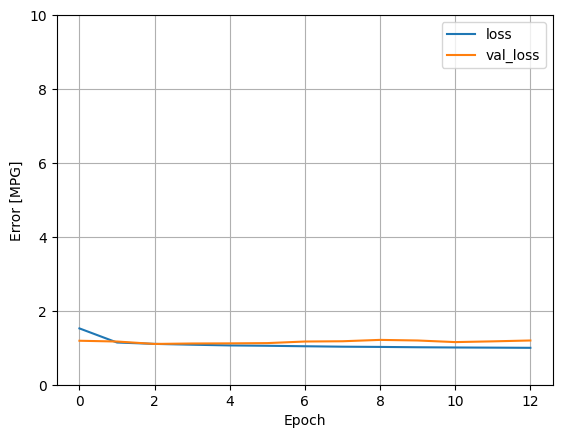

301/301 [==============================] - 0s 785us/step
Label:      2
Prediction: 0
Label:      1
Prediction: 2
Label:      2
Prediction: 0
Label:      3
Prediction: 3
Label:      2
Prediction: 2
Label:      2
Prediction: 3
Label:      1
Prediction: 0
Label:      2
Prediction: 2
Label:      2
Prediction: 3
Label:      2
Prediction: 2
Label:      2
Prediction: 0
Label:      1
Prediction: 0
Label:      1
Prediction: 2
Label:      2
Prediction: 3
Label:      2
Prediction: 1
Label:      2
Prediction: 0
Label:      2
Prediction: 2
Label:      0
Prediction: 0
Label:      1
Prediction: 3
Label:      2
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 0
Label:      1
Prediction: 0
Label:      1
Prediction: 2
Label:      1
Prediction: 0
Label:      2
Prediction: 3
Label:      2
Prediction: 2
Label:      2
Prediction: 1
Label:      2
Prediction: 2
Label:      2
Prediction: 1
Label:      2
Prediction: 1
Label:      2
Prediction: 3
Label:      1
Prediction: 0
Label:      1
Predi

In [48]:
from tensorflow import keras
from keras import metrics
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi as pm

num_features = training_features.shape[1]
print(num_features)
# Define the model architecture
normalizer = keras.layers.BatchNormalization()
model = keras.Sequential([
    # First hidden layer with 256 units and ReLU activation
    keras.layers.Dense(num_features, input_shape=(training_features.shape[1],), activation='relu'), # try relu and sigmoid
    # keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    
    # Second hidden layer with 128 units and ReLU activation
    keras.layers.Dense((num_features * 2/3), activation='relu'),
    # keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    
    # Output layer with num_classes units and softmax activation for multi-class classification
    keras.layers.Dense(num_classes, activation='softmax')
])

"""
optimizer="adam": The optimizer algorithm to use during training. 
Adam optimizer is chosen, which is a popular optimization algorithm known for its efficiency.

loss='categorical_crossentropy': The loss function used to measure the discrepancy between the 
predicted output and the true output labels. Categorical cross-entropy is suitable for
multi-class classification tasks.

metrics=['accuracy']: The metric(s) to be evaluated during training and testing. 
Accuracy is a commonly used metric to assess the model's performance.
"""

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

"""
training_features, train_labels: Input features and corresponding labels for model training.

validation_features, val_labels: Validation set used to monitor the model's performance 
                                         during training.

batch_size=32: Number of samples per gradient update. Training data is divided into batches, 
               and the model's weights are updated after each batch.

epochs=50: Number of times the model will iterate over the entire training dataset.

callbacks: EarlyStopping to stop training if the validation loss does not improve for a certain 
           number of epochs, and ModelCheckpoint to save the best model based on validation loss.
"""

# Encode the training and validation labels using one-hot encoding
train_labels_encoded = to_categorical(training_labels)
val_labels_encoded = to_categorical(validation_labels)

history = model.fit(x=training_features, y=train_labels_encoded, 
                    validation_data=(validation_features, val_labels_encoded),
                    batch_size=10, epochs=50, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)
plt.show()
# Save the entire model to an h5 file
model.save("my_model.h5")

# Use the loaded model for prediction
real_labels = [0,0,0,0]
predicted_labels = [0,0,0,0]
correct = [0,0,0,0]

preds = model.predict(test_features)

for i in range(len(test_labels)):
    real = test_labels[i]
    prediction = np.argmax(preds[i])
    real_labels[real] += 1
    predicted_labels[prediction] += 1

    print("Label:      " + str(real))
    print("Prediction: " + str(prediction))

    if (real == prediction):
        correct[real] += 1

print("Total labels in test data: ", real_labels)
print("Total labels in pred data: ", predicted_labels)
print("correct labels in test data: ", correct)
probabilities = [i / j for i, j in zip(correct, predicted_labels)]
print("prediction probabilities: ", probabilities)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, to_categorical(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)